In [1]:
import pandas

In [2]:
class espion_file:
    """Loader for erg ESPION CSV files into Python"""
    def __init__(self, filepath, filename, species):
        self.basedir = "/Users/angueyraaristjm/Documents/LiData/invivoERG/"
        self.filepath = filepath
        self.filename = filename
        self.fullpath = self.basedir + self.filepath + "/" + self.filename + ".csv"
        self.species = species
        self.metadata = self.pull_metadata()
        self.datatable = self.pull_datatable()
        self.data = self.pull_data()
    
    def pull_metadata(self):
        # pull and parse metadata information
        csvparams = pandas.read_csv(self.fullpath, header=1, usecols=[0, 1], nrows=10)
        csvparams = csvparams.dropna()
        metadata = dict()
        intfields = ["Steps", "Channels"]
        datefields = ["DOB", "Date performed"]
        for i in range(1, 10):
            if csvparams.Parameter[i] in intfields:
                metadata[csvparams.Parameter[i]] = int(csvparams.Value[i])
            elif csvparams.Parameter[i] in datefields:
                metadata[csvparams.Parameter[i]] = pandas.to_datetime(csvparams.Value[i])
            elif csvparams.Parameter[i] == "Family Name":
                metadata["ID"] = csvparams.Value[i]
            else: 
                metadata[csvparams.Parameter[i]] = csvparams.Value[i]
        return metadata
                
    def pull_datatable(self):
        # pull datatable to parse data
        fullcsv = pandas.read_csv(self.fullpath, header=0)
        if "Data Table" in fullcsv:
            print("Data Table is Right")
            datatable = pandas.read_csv(self.fullpath, header=1, usecols=[3, 4, 5, 8])
            datatable = datatable.dropna()
        if fullcsv.ix[12, 0] == "Data Table":
            print("Data Table is Below")
            datatable = pandas.read_csv(self.fullpath, header=1, usecols=[0, 1, 2, 5], skiprows=13)
            datatable = datatable.dropna()
        return datatable
    
    def pull_data(self):
        # parse data based on data table
        fullcsv = pandas.read_csv(self.fullpath, header=0)
        data = espion_step(ch1start=7, ch2start=12-1, ntrials=5, csvtable=fullcsv)
        return data

class espion_step:
    """Loader for a single erg ESPION step"""
    def __init__(self, ch1start, ch2start, ntrials, csvtable):
        colstart = ch1start-1
        colend = colstart+1+(ntrials*2)
        currcsv = csvtable.ix[0:, colstart:colend].copy(deep=0)
        currcsv = currcsv.dropna().reset_index(drop=True)
        currcsv = currcsv.drop(0).reset_index(drop=True)
        colnames = []
        ch1cnt = 0
        ch2cnt = 0
        for i in range(0, len(currcsv.columns)):
            currcsv.ix[0:, i] = pandas.to_numeric(currcsv.ix[0:, i])
            if i == 0:
                colnames.append('t')
            elif 1 <= i < 1+ntrials:
                ch1cnt += 1
                colnames.append('L1_' + str(ch1cnt))
            elif 1+ntrials <= i < 1+(ntrials*2):
                ch2cnt += 1
                colnames.append('R1_' + str(ch2cnt))
        currcsv.columns = colnames
        currcsv = currcsv.divide(1000)
        self.currcsv = currcsv.copy()

In [81]:
a = espion_file("20160422", "01_1sG", "Squirrel")
print("a.datatable is " + str(len(a.datatable.axes[0])) + " x " + str(len(a.datatable.axes[1])))
#b = espion_file("20160422", "02_IseriesXe", "Squirrel")
#print("b.datatable is " + str(len(b.datatable.axes[0])) + " x " + str(len(b.datatable.axes[1])))

Data Table is Below
a.datatable is 2 x 4


In [4]:
print(a.data.currcsv.t.head())

0   -0.100
1   -0.099
2   -0.098
3   -0.097
4   -0.096
Name: t, dtype: float64


In [82]:
import matplotlib
import matplotlib.pyplot as plt
from ipywidgets import interact, SelectMultiple, FloatSlider, Checkbox

plt.style.use('ggplot')
%matplotlib inline
%matplotlib notebook
matplotlib.rc('axes', labelcolor='white') 
matplotlib.rc('xtick', color='white')
matplotlib.rc('ytick', color='white')
matplotlib.rc('font', size=8)
matplotlib.rc('figure', dpi=100)

<IPython.core.display.Javascript object>


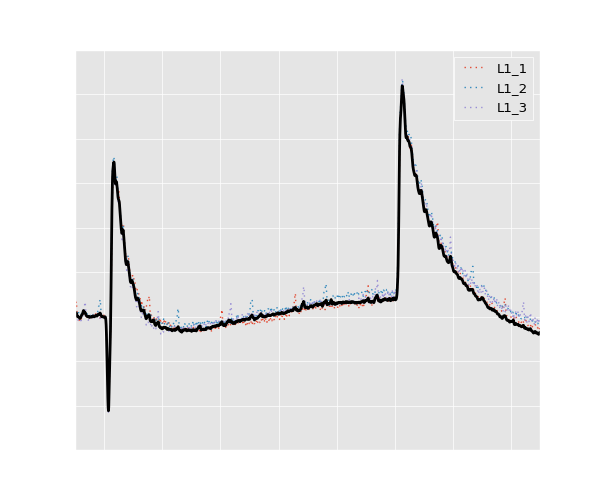

In [122]:
fig = plt.figure(figsize=(6, 5))
aH = fig.add_subplot(111)
#fig = plt.figure()
#aH = fig.add_axes([0.01, 0.01, 1.0, 1.0]) # left, bottom, width, height (range 0 to 1)
aH.title.set_color('white')

aH.set_title("1sG")
aH.set_ylabel("Potential ($\mu$V)")
aH.set_xlabel("Time (s)")

def plot_trial(pdcsv, axishandle, trialname, pbool):
    pdcsv.data.currcsv.plot(x="t", y=trialname, ax=axishandle, ls=":", alpha=pbool, label=trialname)
    return axishandle.lines[-1]

lH1 = plot_trial(a, aH, "L1_1", True)
lH2 = plot_trial(a, aH, "L1_2", True)
lH3 = plot_trial(a, aH, "L1_3", True)
#lH4 = plot_trial(a, aH, "L1_4", True)
#lH5 = plot_trial(a, aH, "L1_5", True)

# alpha_slider = FloatSlider(min=0, max=1, step=.1, value=5)
# @interact(alpha=alpha_slider)
# def modalpha(alpha):
#     print(alpha)
#     lH1.lines[0]set_alpha(alpha)
#a.data.currcsv.plot(x="t", y="R1_1", ax=aH, ls=":")


tme = a.data.currcsv.t
mean = a.data.currcsv[["L1_1", "L1_2", "L1_3", "L1_4", "L1_5"]].mean(axis=1)
lH = aH.plot(tme, mean, label="Mean", color=[0, 0, 0], lw=2)

In [124]:
selected = ToggleButton(True, description='L1_1')
@interact(Selection=selected)
def modalpha(Selection):
    lH1.set_alpha(Selection)

selected2 = ToggleButton(True, description='L1_2')
@interact(Selection=selected2)
def modalpha2(Selection):
    lH2.set_alpha(Selection)

selected3 = ToggleButton(True, description='L1_3')
@interact(Selection=selected3)
def modalpha3(Selection):
    lH3.set_alpha(Selection)
    

In [101]:
ToggleButton?

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact, FloatSlider, RadioButtons, ToggleButton

alpha_slider = ToggleButton(True)
# decorate the plot function with an environment from the UIs:
@interact(alpha=alpha_slider)
def plot(alpha):
    fig, ax = plt.subplots(figsize=(4, 3),
                       subplot_kw={'axisbg':'#EEEEEE',
                                   'axisbelow':True})
    ax.grid(color='w', linewidth=2, linestyle='solid')
    tme = a.data.currcsv.t
    mean = a.data.currcsv[["L1_1", "L1_2", "L1_3", "L1_4", "L1_5"]].mean(axis=1)
    lH = ax.plot(tme, mean, label="Mean", color=[0, 0, 0], lw=2, alpha=alpha)
    
    T1 = a.data.currcsv.L1_1
    lH = ax.plot(tme, T1, label="L1_1", color=[1, 0, 0], lw=1, alpha=alpha)
    

In [ ]:
from ipywidgets import interact, ToggleButton

interact(plot, color=ToggleButton(value = False))